# Gyroscope DDPG reward function testing (spinup library)

In [1]:
# test iter2_base and print all the unsteady states

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from scipy.integrate import solve_ivp
import pandas as pd

import gym_gyroscope_env
import spinup
import torch
from functools import partial

from custom_functions.custom_functions import env_fn 
from custom_functions.custom_functions import create_env
from custom_functions.custom_functions import load_agent
from custom_functions.custom_functions import test_agent
from custom_functions.custom_functions import plot_test
from custom_functions.custom_functions import evaluate_control

import random
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

## Plot rewards

In [3]:
def read_progress(agent_path):
    
    # count lines
    file = open(agent_path+"/progress.txt", "r")
    count = len(file.readlines())
    data = np.empty([count-1, 19])
    file.seek(0)
    
    # read each line as a numpy array
    for row, x in enumerate(file):
        if row == 0:
            continue
        data[row-1] = np.array(x.split('\t')).astype(np.float)
    file.close()
    
    return data

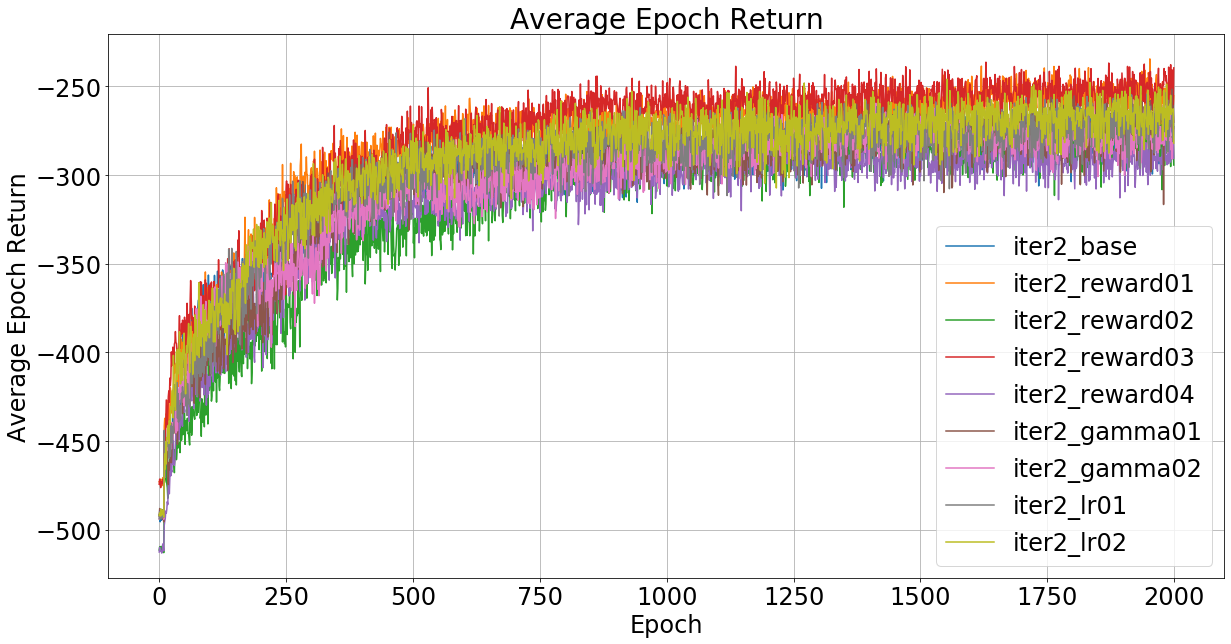

In [4]:
plt.figure(figsize=(20,10))
plt.title('Average Epoch Return',fontsize=28)
plt.xlabel('Epoch',fontsize=24)
plt.xticks(fontsize=24)
plt.ylabel('Average Epoch Return',fontsize=24)
plt.yticks(fontsize=24)
plt.grid()

agent_paths = ['iter2_base','iter2_reward01','iter2_reward02','iter2_reward03','iter2_reward04',
              'iter2_gamma01','iter2_gamma02','iter2_lr01','iter2_lr02']

for agent_path in agent_paths[:]:
    progress = read_progress(agent_path)
#     print(agent_path, len(progress))
    plt.plot(np.arange(progress.shape[0]), progress[:,1])
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,3], progress[:,4], alpha=0.5)
#     plt.fill_between(np.arange(progress.shape[0]), progress[:,1]+progress[:,2], progress[:,1]-progress[:,2], alpha=0.5)

# plt.xlim([0,500])
# plt.ylim([-2000,0])
plt.legend(agent_paths,fontsize=24)

## Test an agent

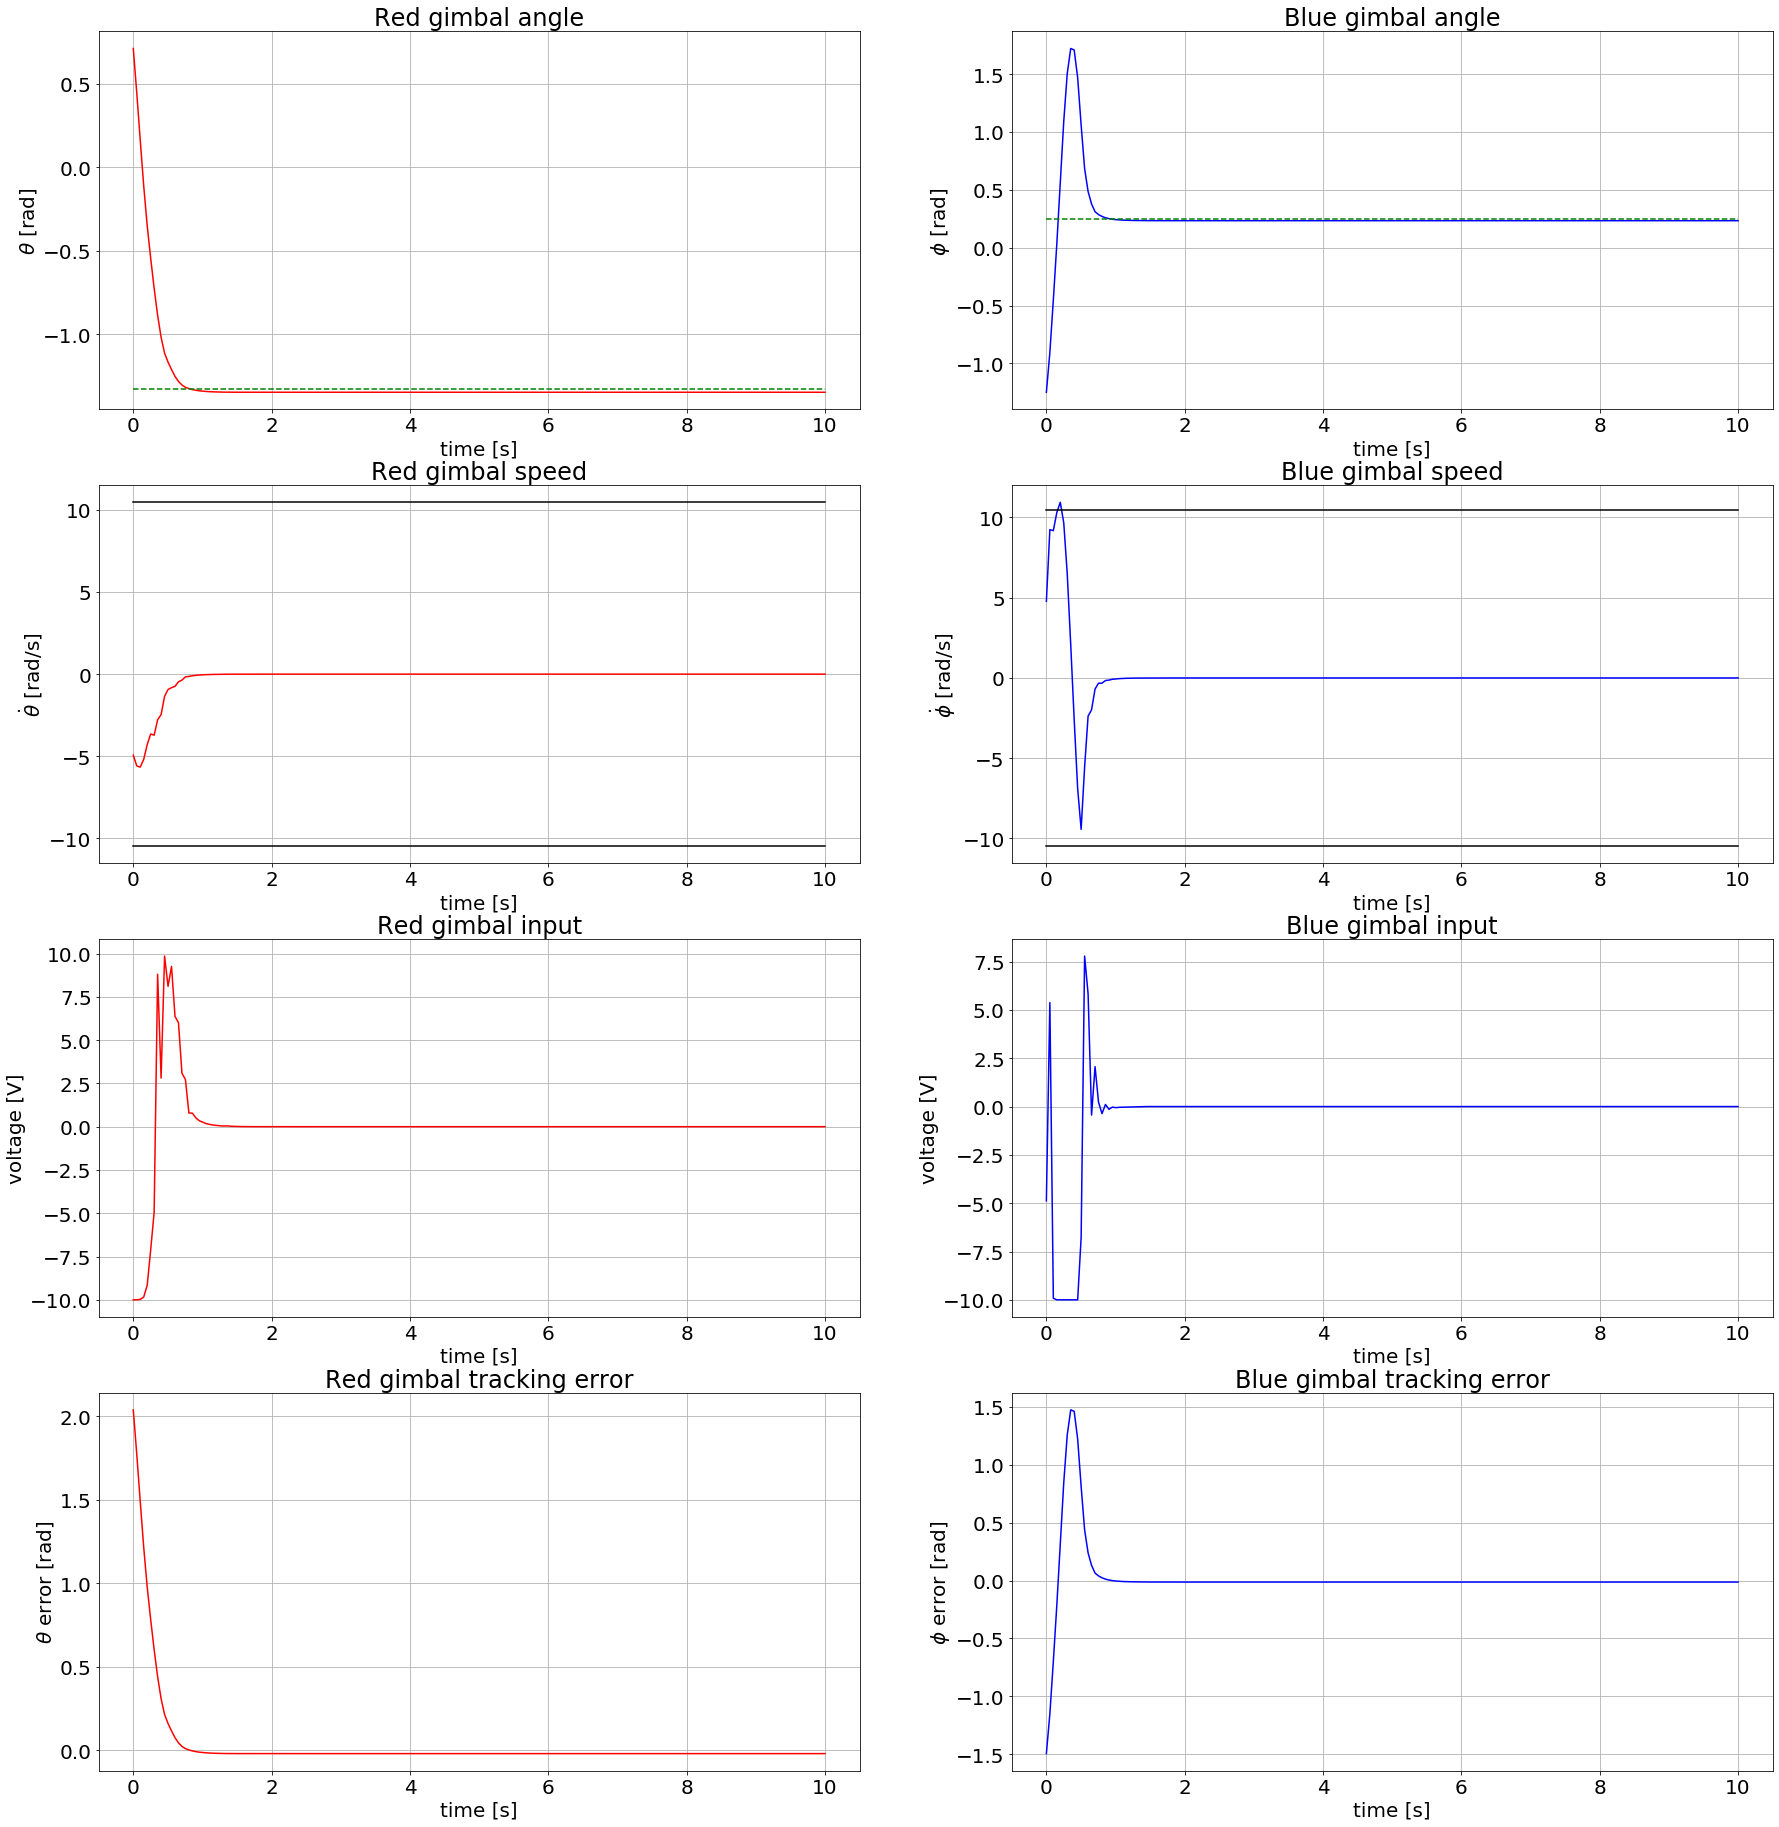

In [18]:
# Test paramaters
env_name = 'GyroscopeEnv-v1'

init_state = np.array([0,0,0,0,45/180*np.pi,-60/180*np.pi,200/60*2*np.pi])
env = create_env(env_name,state=None)

agent_paths = ['iter2_base','iter2_reward01','iter2_reward02','iter2_reward03','iter2_reward04',
              'iter2_gamma01','iter2_gamma02','iter2_lr01','iter2_lr02','iter2_final']

agent = load_agent(agent_paths[-1])
t_end = 10

score, state_record, obs_record, action_record, reward_record = test_agent(env,agent,t_end)
plot_test(state_record, action_record, t_end, 4)

In [ ]:
time = np.linspace(0, t_end, len(state_record))

f, axs = plt.subplots(n,2,figsize=(30,8*n))

plt.subplot(n,2,1)
plt.title('Red gimbal angle',fontsize=24)
plt.xlabel('time [s]',fontsize=20)
plt.ylabel(r'$\theta$ [rad]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.plot(time,angle_normalize(state_record[:,0]),'r-')
plt.plot(time,angle_normalize(state_record[:,4]),'g--')
# plt.plot(time,np.full(len(time),180), 'k-')
# plt.plot(time,np.full(len(time),-180), 'k-')

plt.subplot(n,2,2)
plt.title('Blue gimbal angle',fontsize=24)
plt.xlabel('time [s]',fontsize=20)
plt.ylabel(r'$\phi$ [rad]',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.plot(time,angle_normalize(state_record[:,2]),'b-')
plt.plot(time,angle_normalize(state_record[:,5]),'g--')
# plt.plot(time,np.full(len(time),180), 'k-')
# plt.plot(time,np.full(len(time),-180), 'k-')

## Evaluate control performance

In [32]:
iter2_metrics = pd.read_csv('iter2_metrics.csv')
pd.set_option('display.max_columns', None)
iter2_metrics

,Unnamed: 0,iter2_base,iter2_reward01,iter2_reward02,iter2_reward03,iter2_reward04,iter2_gamma01,iter2_gamma02,iter2_lr01,iter2_lr02
0,$\theta$ MAE (rad),0.1088,0.0944,0.0996,0.0981,0.1096,0.2068,0.0955,0.1944,0.2158
1,$\phi$ MAE (rad),0.0675,0.0678,0.0734,0.0785,0.0718,0.0697,0.0778,0.0672,0.0561
2,$\theta$ MSSE (rad),0.0203,0.0137,0.0150,0.0174,0.0236,0.0914,0.0181,0.0921,0.0946
3,$\phi$ MSSE (rad),0.0128,0.0140,0.0140,0.0151,0.0158,0.0196,0.0203,0.0134,0.0119
4,$\theta$ in bounds (%),99.7700,99.8800,99.7700,99.6900,99.3500,96.1000,99.9100,95.9500,95.8000
5,$\phi$ in bounds (%),99.9300,99.9000,99.8300,99.3000,99.7200,99.0900,99.6400,99.5000,99.5800
6,$\theta$ unsteady (%),0.0100,0.0300,0.0900,0.0600,0.1500,0.6900,0.0000,0.5900,0.9500
7,$\phi$ unsteady (%),0.0500,0.0900,0.0800,0.3100,0.1400,0.4900,0.0200,0.4200,0.4100
8,$\theta$ rise time (s),0.5340,0.4828,0.4901,0.4721,0.5099,0.6022,0.4981,0.5484,0.6078
9,$\phi$ rise time (s),0.3279,0.3232,0.3439,0.3525,0.3220,0.2919,0.3461,0.3212,0.2769


In [2]:
iter2_final_metrics = pd.read_csv('iter2_final_metrics.csv')
pd.set_option('display.max_columns', None)
iter2_final_metrics

,Unnamed: 0,iter2_final
0,$\theta$ MAE (rad),0.0878
1,$\phi$ MAE (rad),0.0646
2,$\theta$ MSSE (rad),0.0120
3,$\phi$ MSSE (rad),0.0100
4,$\theta$ in bounds (%),99.9600
5,$\phi$ in bounds (%),99.9900
6,$\theta$ unsteady (%),0.0000
7,$\phi$ unsteady (%),0.0000
8,$\theta$ rise time (s),0.4857
9,$\phi$ rise time (s),0.3194
